# Attempting to Model Elevator Situation with SimPy
## The Problem
My apartment building has three elevators, but one is reserved for freight. So, it really has two elevators which are called with one button. 

One of the elevators broke down, so the building opened the freight elevator up to the residents to increase throughput. The freight elevator has its own button, which works independently of the passenger elevator.

I noticed one day as I was descending that the elevator kept stopping and no one would get in. I realized the people in my building had started pressing both buttons and then getting in the elevator that arrived first.

That got me thinking. Is that optimal? Are we all worse off because of this?

Here are my research questions:
1. Are we all worse off if everyone does this behavior?
2. Is there a threshold for how many people have to do this to make it worse?
3. Can we solve this problem through simulation and probability (numerical and analytical)?

My first attempt at solving this is to run a simulation in Python

# Dependencies

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Simplifying Assumptions
- Elevator going down picks up people that want to be picked up (regardless of when they push button)
- If someone gets on at a non lobby floor, they're going to the lobby
- Elevator drops off passengers on its way up and on the way down at the lobby
- Half of the customers come on at the lobby, the other half come on with equal likelihood on the residential floors
- When an elevator stops, it stops for 5 seconds (initial parameter)
- An elevator travels one floor per second (initial parameter)

# Defining an Elevator Class
We're going to have multiple elevators, which all do the same thing. Good time to make a class!

In [2]:
class Elevator(object):
    def __init__(self, name, debug=False, wait_time=5, n_floors=23):
        self.name = name
        self.wait_time = wait_time
        self.n_floors = n_floors
        self.loc = 0 # current floor
        self.moving_up = True # default is true because elevator starts on ground
        self.to_pick_up, self.to_drop_off = [], []
        self.stopped = 0 # works as a timer, if its zero, not stopped
        self.idle = True # Elevator isn't doing anything
        self.throughput = 0# number of customers served
        self.average_times = []
        self.time = 0
        self.debug = debug
        
    def __str__(self):
        ans = self.name + ': '
        if self.idle:
            ans += 'idle'
        elif self.stopped > 0:
            ans += 'stopped'
        elif self.should_stop():
            ans += 'stopping to pick up or drop off'
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            ans += 'switching to idle'
        else:
            ans += f'moving, moving_up: {self.moving_up}'
        ans += '\npassenger dests: ' + ', '.join([str(cust.dest) for cust in self.to_drop_off]) 
        return ans
    
    def move(self, time):
        self.time = time
        if self.idle:
            return
        elif self.stopped > 0:
            # if stopped, stay stopped
            # can pick up more customers
            self.stopped -= 1
            self.pick_up()
            self.drop_off()
        elif self.should_stop():
            self.pick_up_and_drop_off()
        elif len(self.to_drop_off) == 0 and len(self.to_pick_up) == 0:
            self.idle = True
        else:
            self.loc += 1 if self.moving_up else -1
            if self.loc > self.n_floors: # bounds checking
                self.loc = self.n_floors
                self.moving_up = False
            if self.loc < 0:
                self.loc = 0
                self.moving_up = True 
                
    def should_stop(self):
        if self.moving_up: # stop to drop off people
            if len(self.to_drop_off) == 0: # elevator is empty, picking heads up
                for customer in self.to_pick_up:
                    if customer.curr == self.loc:
                        return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
        else:
            for customer in self.to_pick_up:
                if customer.curr == self.loc:
                    return True
            for customer in self.to_drop_off:
                if customer.dest == self.loc:
                    return True
                
    def new_customer(self, customer):
        self.to_pick_up.append(customer)
        self.idle = False
    
    def pick_up(self):
        for customer in self.to_pick_up:
            if customer.curr == self.loc:
                self.to_pick_up.remove(customer)
                if customer.on_elevator == None:
                    # customer isn't already on an elevator
                    if self.debug:
                        print(f'{self.name} picked up customer {customer} at floor {self.loc}')

                    self.to_drop_off.append(customer)
                    customer.on_elevator = self
                
    def drop_off(self):
        for customer in self.to_drop_off:
            if customer.dest == self.loc:
                if self.debug:
                    print(f'{self.name} dropped off customer {customer} at floor {self.loc}')
                self.to_drop_off.remove(customer)
                self.average_times.append(self.time-customer.start_time)
                self.throughput += 1

    def pick_up_and_drop_off(self):
        # dropping people off
        # which direction to proceed?
        if self.moving_up:
            # elevators only drops off on the way up, unless its the last stop
            self.drop_off()
            
            # keep moving up if:
            # people need to be dropped off above current location
            # possibly: elevator is empty and people need to be picked up above current location
            continue_moving_up = False
            for cust in self.to_drop_off:
                if cust.dest > self.loc:
                    continue_moving_up = True
                    break
            self.moving_up = continue_moving_up            
        if not self.moving_up:
            # keep moving down, unless you're at the lobby 
            self.pick_up() 
            if self.loc == 0: # at lobby, drop people off
                self.drop_off()
            self.moving_up = True if self.loc == 0 else False

        self.stopped = self.wait_time # need to stop to pick people up


# Define Customer Class
The customer class does not have much logic. The key is to randomly generate current floor and destination floor.

In [3]:
class Customer(object):
    def __init__(self, start_time, cust_number, n_floors=23, percent_lobby=.5):
        self.number = cust_number
        rand = np.random.random()
        randint = np.random.randint(3, n_floors+1)
        # half the time, someone gets on at the lobby, other half someone gets on a random floor
        self.curr, self.dest = (0, np.random.randint(3,23)) if rand <= percent_lobby else (np.random.randint(3,23), 0) 
        self.start_time = start_time
        self.on_elevator = None # which elevator customer entered
        
    def __str__(self):
        return f'customer number: {self.number}, location: {self.curr}, destination: {self.dest}'

# Plotting Function to Visualize the Hotel at a Given Time

In [4]:
def plot_hotel(e1, e2, n_floors):
    text_output = ''
    customers_waiting = list(set(e1.to_pick_up) | set(e2.to_pick_up))
    for i in range(n_floors, -1, -1):
        text_output += f'\nfloor {i}: '
        if e1.loc == i:
            text_output += str(e1) + ' '
        if e2.loc == i:
            text_output += str(e2) + ' '
        
        for c in customers_waiting:
            if c.curr == i:
                text_output += 'X'
    return text_output + '\n'

# Define Parameters and Run Simulation

Each iteration of the for loop will symbolize one second in this simulation. This is convenient because I avoid having to use actual timing.

## Simulating Arrivals
I am sampling a poisson distribution to determine arrival time. The lambda in this case is the number of seconds it takes for a passenger to call the elevator. I then take the cumulitive sum of this sampling, and this gives the seconds over the simulation that a passenger arrives.

## Poisson Distribution Assumptions
One important poisson assumption is that lambda is constant. Of course, it's not in my hotel. But for the purpose of this, I'm going to assume there's one hour that's relatively busy where a person calls an elevator every 20 seconds.

In [115]:
def simulation(button_press_func=None, time_steps=3600, wait_time=5, poisson_lambda=20, n_floors=23, debug=False, 
              percent_lobby=.5):
    cust_number = 0
    arrivals = np.random.poisson(lam=poisson_lambda, size=10000).cumsum()
    e1 = Elevator('Service Elevator')
    e2 = Elevator('Regular Elevator')
    for i in range(time_steps):
        if debug:
            print(f'time step {i}')
            print(plot_hotel(e1, e2, n_floors))
        e1.move(i)
        e2.move(i)
        if i in arrivals:
            cust_number += 1
            temp = Customer(i, cust_number, n_floors=n_floors, percent_lobby=percent_lobby)
            if debug:
                print(f'customer wants to get picked up at {temp.curr} and dropped off at {temp.dest}')
            if button_press_func == None:
                print('ERROR! Define the way passengers press buttons')
                return e1, e2
            button_press_func(temp, e1, e2)
    return e1, e2

# Creating Decision Function for Which Button to Press

In [116]:
def press_both(temp, e1, e2):
    e1.new_customer(temp)
    e2.new_customer(temp)
    
press_both_sim = simulation(button_press_func=press_both, debug=False, time_steps=3600)

# Plotting
Let's look at the histogram of time spent for each customer. I'll also output a few statistics of interest, like throughput, average time, and worst case time

In [177]:
np.quantile(e1.average_times, .75)

39.75

Service Elevator throughput: 86
Service Elevator mean elevator time: 35.33720930232558
Regular Elevator throughput: 86
Regular Elevator mean elevator time: 38.58139534883721
combined mean elevator time: 36.9593023255814
Worst trip time was 297


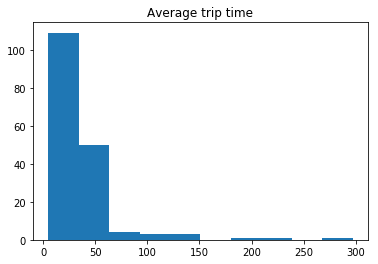

In [117]:
def display_results(e1, e2):
    combined_times = e1.average_times + e2.average_times
    for e in [e1,e2]:
        print(f'{e.name} throughput: {e.throughput}')
        print(f'{e.name} Median elevator time: {np.median(e.average_times)}')
    fig = plt
    fig.title('Average trip time')
    fig.hist(combined_times)
    print(f'combined median elevator time: {np.median(combined_times)}')
    print(f'Worst trip time was {max(combined_times)}')
    
display_results(*press_both_sim)

# Comparing Average Times Based on Button Pressing
Seeing the average times is useful, but we still need to compare different behaviors. Is double pressing worse than single pressing?

Single pressing will be blind. At random, the patron will choose which elevator to call.

Service Elevator throughput: 92
Service Elevator mean elevator time: 35.95652173913044
Regular Elevator throughput: 83
Regular Elevator mean elevator time: 41.734939759036145
combined mean elevator time: 38.69714285714286
Worst trip time was 174


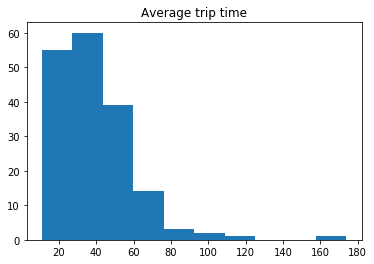

In [118]:
def press_one(temp, e1, e2):
    if np.random.randint(2):
        e1.new_customer(temp)
    else:
        e2.new_customer(temp)
        
press_one_sim = simulation(button_press_func=press_one, debug=False)
display_results(*press_one_sim)

# Comparisons
Look at the average results. If everyone presses both buttons, we get about 37 seconds of average travel time. If everyone presses one button, we get about 39 seconds of average travel time. I'm not too confident about these results because this is only one trial. We'll be more rigorous later.

Looking more closely at the histogram reveals an interesting result. The tail if everyone presses both buttons is longer. This means, everyone does a bit better on average, but the worst case is also worse. The worst case if everyone pressed both buttons is about two minutes longer! Yea, on average we go slightly faster (2 seconds) but we can potentially have a much longer ride. 

This is a good example of mean being a misleading statistic if the distribution is not Gaussian (not a normal curve). We have these long tails, which are hidden if we focus only on the mean. We should focus on the median!

# Looking for an Optimal Split
We define a function that either presses one or both buttons. Let's look for the best possible arrangement. We'll also run multiple trials so we have more robust results.

In [119]:
def press_one_or_two(temp, e1, e2, prob):
    if np.random.random() < prob:
        press_one(temp, e1, e2)
    else:
        press_both(temp, e1, e2)

In [148]:
probabilities = np.linspace(0, 1, num=11)
results = {}
n_trials = 100
for p in probabilities:
    def press_one_or_two(temp, e1, e2):
        print(temp)
        print(e1)
        print(e2)

        if np.random.random() < p:
            press_one(temp, e1, e2)
        else:
            press_both(temp, e1, e2)
    temp = []
    for i in range(n_trials):
        temp.append(simulation(button_press_func=press_both, time_steps=3600))
    results[p] = temp

In [149]:
mean_dict, worst_dict = {}, {}
for p, result in results.items():
    temp_means = []
    temp_worsts = []
    for e1, e2 in result:
        temp_means.append(np.median(e1.average_times+e2.average_times))
        temp_worsts.append(np.max(e1.average_times+e2.average_times))
    mean_dict[p] = temp_means
    worst_dict[p] = temp_worsts

def plot_dict(adict):
    xs = adict.keys()
    ys = [np.mean(x) for x in adict.values()]
    errors = [np.std(x) for x in adict.values()]
    plt.errorbar(xs, ys, yerr=errors)
    plt.xlabel('Percent of People who Press One Button')
    plt.ylabel('Time')

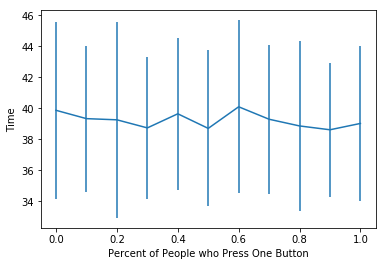

In [150]:
plot_dict(mean_dict)

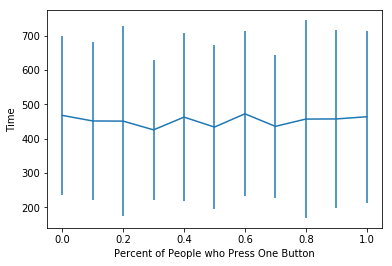

In [151]:
plot_dict(worst_dict)

# What Next?
So, from these plots it looks like our simulations are almost random. We ran 100 trials, but they are incredibly variable. One reason for this might be that we have a short time for the simulation. Let's re-run it but simulate over 24 hours.

In [156]:
probabilities = np.linspace(0, 1, num=11)
results = {}
n_trials = 200
for p in probabilities:
    def press_one_or_two(temp, e1, e2):
        print(temp)
        print(e1)
        print(e2)

        if np.random.random() < p:
            press_one(temp, e1, e2)
        else:
            press_both(temp, e1, e2)
    temp = []
    for i in range(n_trials):
        temp.append(simulation(button_press_func=press_both, time_steps=3600))
    results[p] = temp

In [157]:
mean_dict, worst_dict = {}, {}
for p, result in results.items():
    temp_means = []
    temp_worsts = []
    for e1, e2 in result:
        temp_means.append(np.mean(e1.average_times+e2.average_times))
        temp_worsts.append(np.max(e1.average_times+e2.average_times))
    mean_dict[p] = temp_means
    worst_dict[p] = temp_worsts

def plot_dict(adict):
    xs = adict.keys()
    ys = [np.mean(x) for x in adict.values()]
    errors = [np.std(x) for x in adict.values()]
    plt.errorbar(xs, ys, yerr=errors)
    plt.xlabel('Percent of People who Press One Button')
    plt.ylabel('Time')

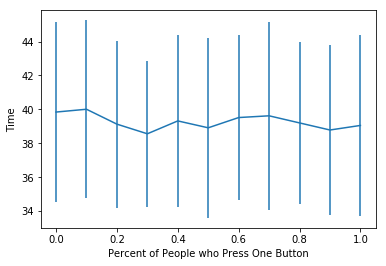

In [158]:
plot_dict(mean_dict)

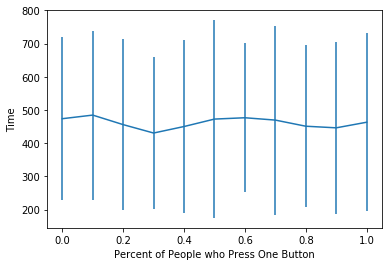

In [159]:
plot_dict(worst_dict)

Seemingly, no number of trials and no simulation length will lead to a definitive claim. I guess for now, there is not much difference in pressing both buttons versus pressing one. 

Mildly disappointing. :(

But, let's look back to the insights from the first run. Our Gaussian assumptions lead to misunderstanding the actual data. By plotting this data with an error bar, we again assume a Gaussian distribution.

We know we are dealing with a right skewed distribution, so let's take a look at outlier-resistant statistics. 

# One More Try
Let's not look for an optimal probability. Just compare pressing both or pressing one.


In [165]:
n_trials = 100
press_one_sims = []
press_both_sims = []
for i in range(n_trials):
    press_one_sims.append(simulation(button_press_func=press_one, time_steps=3600))    
    press_both_sims.append(simulation(button_press_func=press_both, time_steps=3600))

In [166]:
one_times = []
both_times = []
for i in range(n_trials):
    e1, e2 = press_one_sims[i]
    one_times += e1.average_times
    one_times += e2.average_times
    
    e1, e2 = press_both_sims[i]
    both_times += e1.average_times
    both_times += e2.average_times

In [202]:
def summary_statistics(oen_times, two_times):
    print(f'Median for one press: {np.median(one_times)}')
    print(f'Median for both press: {np.median(two_times)}')

    xs = []
    one_ys = []
    two_ys = []
    for i in range(1, 100):
        quant = .01*i
        xs.append(i)
        one_ys.append(np.quantile(one_times, quant))
        two_ys.append(np.quantile(two_times, quant))
        #print(f'{quant} quantile: {np.quantile(times, quant)}')
    plt.plot(xs, one_ys, label='One Button')
    plt.plot(xs, two_ys, label='Both Buttons')
    plt.legend()
    plt.xlabel('Quantile')
    plt.ylabel('Time')
    #    plt.hist(times)

Median for one press: 34.0
Median for both press: 28.0


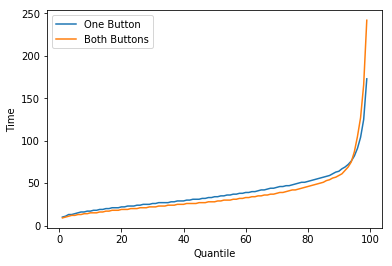

In [203]:
summary_statistics(one_times, both_times)

Interesting. Around the 95th quantile, pressing both buttons significantly increases elevator time. However, in general it is faster.

So, if everyone chooses to press both buttons, we get a 6 second speed up, at the expense of a 2 minute worse, worst case scenario.